In [1]:
import os, sys
from collections import defaultdict 
import time

import numpy as np

sys.path.append('../../../../../../../../notebooks/visual_genome/visual_genome_python_driver_master')
sys.path.append('../../../../../../../../notebooks/visual_genome/visual_genome_python_driver_master/visual_genome')

import visual_genome.local as vg

import nltk
from nltk.corpus import wordnet as wn

## Load all Scene Graphs

"scene_graphs.npy" has been pre-saved in a 800Mb npy file. It takes about 2h to be generated.

In [2]:
scene_graphs = np.load("scene_graphs.npy", allow_pickle=True)

## Get Wordnet Synsets

Through Depth First Search:
    
1. Get the TOP parent synsets "top_synset_list" starting from synset target (e.g. "zebra.n.01") that are either:
    - "depth_up" from target OR
    - have no parent synset



2. Get ALL synsets "all_synset_list" below the TOP parent synsets that are "depth_down" distant from each of them.

In [3]:
# Recursive Depth First Search (DFS) auxiliar function
def DFS_rec(synset, visited, depth, max_depth, top_synset_list, all_synset_list, up):

    visited[synset] = True

    all_synset_list.append(synset.name())
    
    depth += 1
    if depth <= max_depth:
        
        if up:
            next = synset.hypernyms()
        else:
            next = synset.hyponyms()
        
        if len(next) == 0:
            top_synset_list.append(synset.name())
            
        for s in next:
            if not visited[s]: 
                DFS_rec(s, visited, depth, max_depth, top_synset_list, all_synset_list, up=up)
                
    else:
        top_synset_list.append(synset.name())

# Depth First Search (DFS) entry function        
def DFS(synset_name_list, max_depth, up=False):
    
    top_synset_list = []
    all_synset_list = []

    visited = defaultdict(bool)
    for synset_name in synset_name_list:
        DFS_rec(wn.synset(synset_name), visited, 0, max_depth, top_synset_list, all_synset_list, up=up)
    
    return top_synset_list, all_synset_list


def get_synsets_from_target(target, depth_up, depth_down):
    
    max_depth = depth_up
    top_synset_list, _ = DFS([target], max_depth, up=True)
    
    max_depth = depth_down
    _ , all_synset_list = DFS(top_synset_list, max_depth)  
    
    return all_synset_list


In [4]:
all_synset_list = get_synsets_from_target("car.n.01", 1, 1)
all_synset_list

['motor_vehicle.n.01',
 'amphibian.n.01',
 'bloodmobile.n.01',
 'car.n.01',
 'doodlebug.n.01',
 'four-wheel_drive.n.01',
 'go-kart.n.01',
 'golfcart.n.01',
 'hearse.n.01',
 'motorcycle.n.01',
 'snowplow.n.01',
 'truck.n.01']

## Get Visual Genome Synsets

Get the sysnsets that are in "all_synset_list", from Wordnet that are available in Visual Genome

In [5]:
def get_all_object_synsets():

    object_synsets = set()

    for sg in scene_graphs:
        for obj in sg.objects:
            for syn in obj.synsets:
                object_synsets.add(syn.name)
                
    return object_synsets

all_object_synsets = get_all_object_synsets()

In [6]:
target_object_synsets = list(all_object_synsets & set(all_synset_list))
target_object_synsets

['four-wheel_drive.n.01',
 'snowplow.n.01',
 'motor_vehicle.n.01',
 'car.n.01',
 'golfcart.n.01',
 'motorcycle.n.01',
 'truck.n.01',
 'hearse.n.01']

## Get Concepts from Target

Get the "TOP_N" most present concepts "concept_set" in the target (e.g. "zebra") when the Scene Graph (SG) contains:
1. A relationship with "OF" or "ON" "predicate" and target is in the "object" OR
2. A relationship with "has" "predicate" and target is in the "subject"

In [7]:
def get_concepts_from_target(target):
    
    concepts_set = defaultdict(int)
    for sg in scene_graphs:
        for rel in sg.relationships:
        
            if rel.predicate in ["OF", "ON"] and target in str(rel.object):
                concepts_set[str(rel.subject).split()[-1]] += 1

            elif rel.predicate in ["has"] and target in str(rel.subject):
                concepts_set[str(rel.object).split()[-1]] += 1
    
    return concepts_set

In [8]:
TOP_N = 5
TARGET = "car"
concepts_set = get_concepts_from_target(TARGET)
concepts_set = list({k: v for k, v in sorted(concepts_set.items(), key=lambda item: item[1])})[-TOP_N:]
concepts_set

['plate', 'light', 'wheel', 'window', 'tire']

## Get All Concepts Regions

Get all regions when the Scene Graph (SG) contains:

1. A relationship with "OF" or "ON" "predicate" AND 
   synsets from "all_synset_list" are in the "object" AND
   concepts from "concepts_set" are in the "subject" OR
   

2. A relationship with "has" "predicate" AND 
   synsets from "all_synset_list" are in the "subject" AND
   concepts from "concepts_set" are in the "object"

In [9]:
def get_regionimages_from_concepts(concepts_set, synset_list):
    
    concept_regions = defaultdict(list)
    
    for concept in concepts_set:
        for sg in scene_graphs:
            for rel in sg.relationships:
            
                if rel.predicate in ["OF", "ON"] and concept in str(rel.subject):
                    for synset in synset_list:
                        if rel.object.synsets and synset == rel.object.synsets[0].name:
                            concept_regions[concept].append((sg.image.id, rel.subject.x, rel.subject.y, rel.subject.width, rel.subject.height))
                                
                elif rel.predicate in ["has"] and concept in str(rel.object):
                    for synset in synset_list:
                        if rel.subject.synsets and synset == rel.subject.synsets[0].name:
                            concept_regions[concept].append((sg.image.id, rel.object.x, rel.object.y, rel.object.width, rel.object.height))
               
    return concept_regions

In [10]:
concept_regions = get_regionimages_from_concepts(concepts_set, target_object_synsets)

# Remove duplicates
for concept in concept_regions:
    concept_regions[concept] = list(set(concept_regions[concept]))

print([(i, len(concept_regions[i])) for i in concept_regions])

[('plate', 812), ('light', 2971), ('wheel', 1736), ('window', 1060), ('tire', 1821)]


## Create Concepts

Create N_CONCEPTS image concepts per concept name in designated disk folders.

In [11]:
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


def create_concept_images(concept_regions, margin=0):
        
    image_path = "visual_genome/visual_genome_python_driver-master/visual_genome/data/images/"
    concepts_path = "./concepts-vg/"

    for c, concept_name in enumerate(concept_regions):
        
        dir_path = os.path.join(concepts_path, concept_name)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        
        #for i in range(len(concept_regions[concept_name])):
        for i in range(N_CONCEPTS):
        
            image = concept_regions[concept_name][i]

            img_id = image[0]
            x = image[1]
            y = image[2]
            w = image[3]
            h = image[4]

            img_file = image_path + str(img_id) + '.jpg'
            img = Image.open(img_file).crop((x, y, x+w, y+h)).convert("RGB")
            img = transform(img)
                
            save_path = os.path.join(dir_path, concept_name + '_{:04d}'.format(i) + '.jpg')
            save_image(img, save_path)

            
N_CONCEPTS = 50
create_concept_images(concept_regions)

## Visualize

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image as PIL_Image

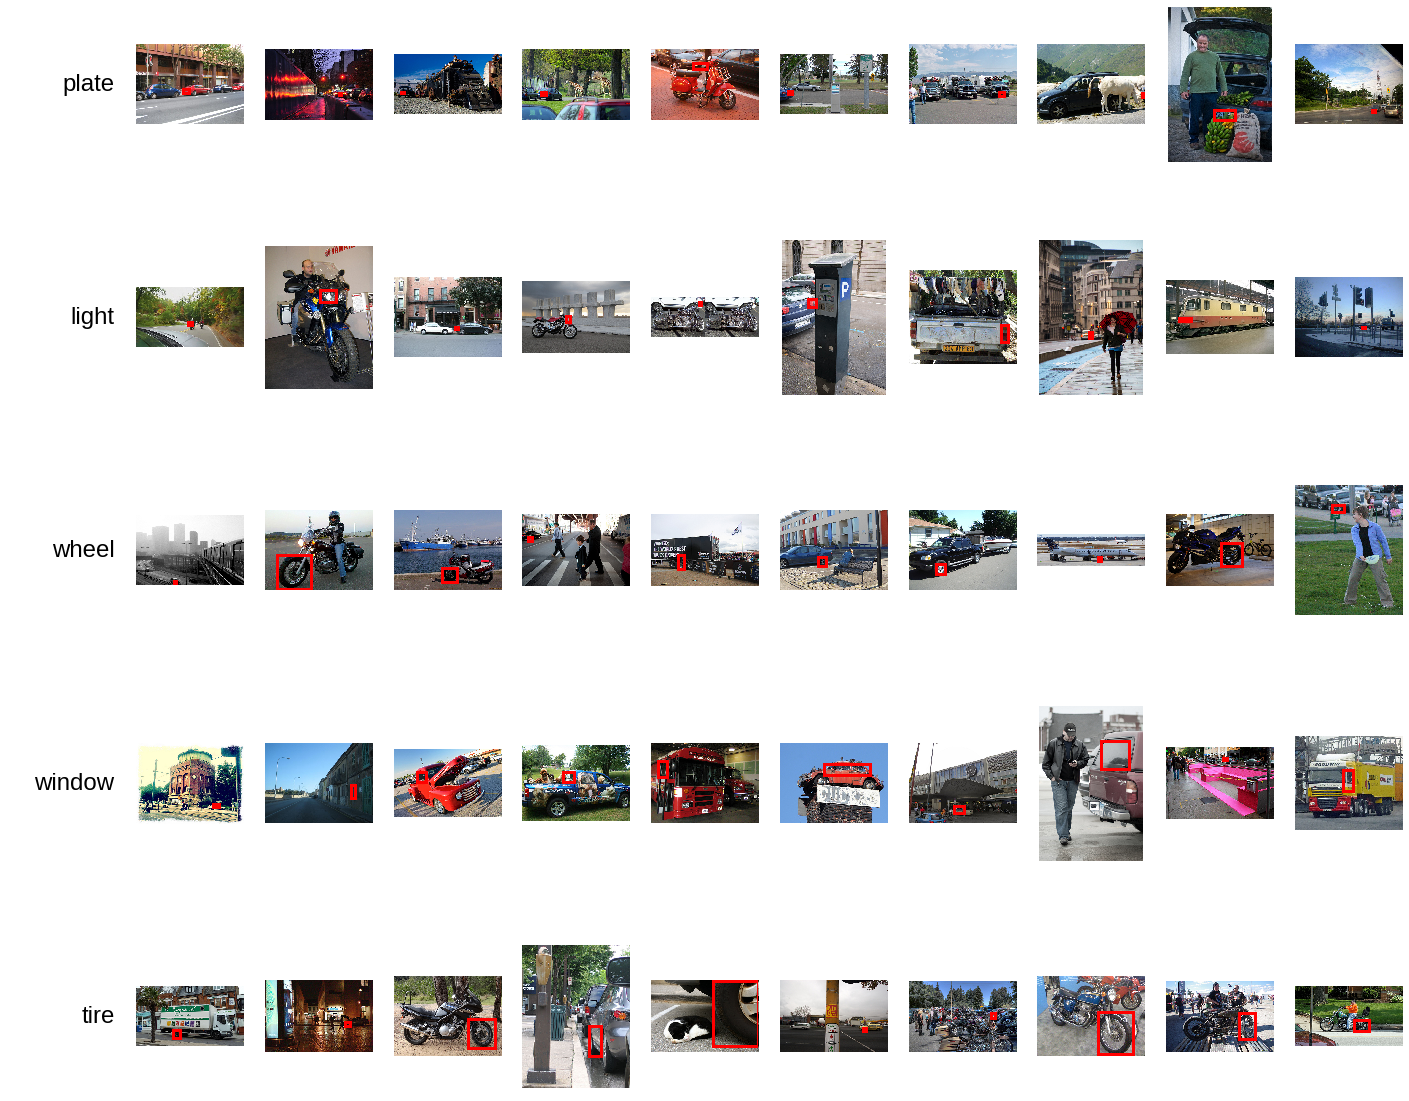

In [13]:
n_figs = 10
n_concepts = len(concept_regions)
image_path = 'visual_genome/visual_genome_python_driver-master/visual_genome/data/images/'
margin = 0

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept_name in enumerate(concept_regions):

    for i in range(n_figs + 1):
            
        if i == 0:
            axs[c, i].text(1.0, 0.5, str(concept_name), ha='right', va='center', family='sans-serif', size=24)
        else:
            image = concept_regions[concept_name][i]
            img_file = image_path + str(image[0]) + '.jpg'
            img = mpimg.imread(img_file)
            axs[c, i].add_patch(Rectangle((image[1], image[2]),
                                image[3],
                                image[4],
                                fill=False,
                                edgecolor='red',
                                linewidth=3))
            #img = img[image[2] - margin:image[2] + image[4] + margin, image[1] - margin:image[1] + image[3] + margin, :]
            axs[c, i].imshow(img)
            
        axs[c, i].axis('off')

plt.show()
